=== Feature Summary ===
             permno                           date         ofi     ofi_abs  \
count    396.000000                            396  396.000000  396.000000   
mean   51070.333333  2023-01-07 11:45:27.272727296    0.017145    0.093076   
min    11618.000000            2022-12-20 00:00:00   -0.380524    0.000357   
25%    19502.000000            2023-01-04 00:00:00   -0.059295    0.040312   
50%    49656.000000            2023-01-09 00:00:00    0.028585    0.083430   
75%    72726.000000            2023-01-12 00:00:00    0.095136    0.128960   
max    92655.000000            2023-01-20 00:00:00    0.410825    0.410825   
std    28384.392560                            NaN    0.114390    0.068519   

          ofi_std    buy_volume   sell_volume        volume    num_trades  \
count  396.000000  3.960000e+02  3.960000e+02  3.960000e+02    396.000000   
mean     0.170756  9.321405e+05  8.872291e+05  1.820045e+06  18139.068182   
min      0.051685  4.296400e+04  3.981900e

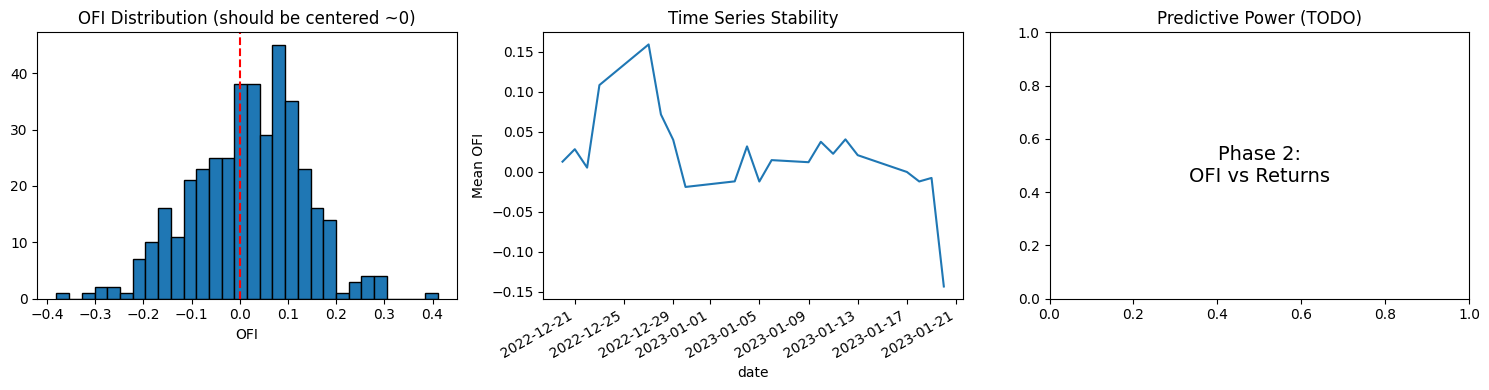

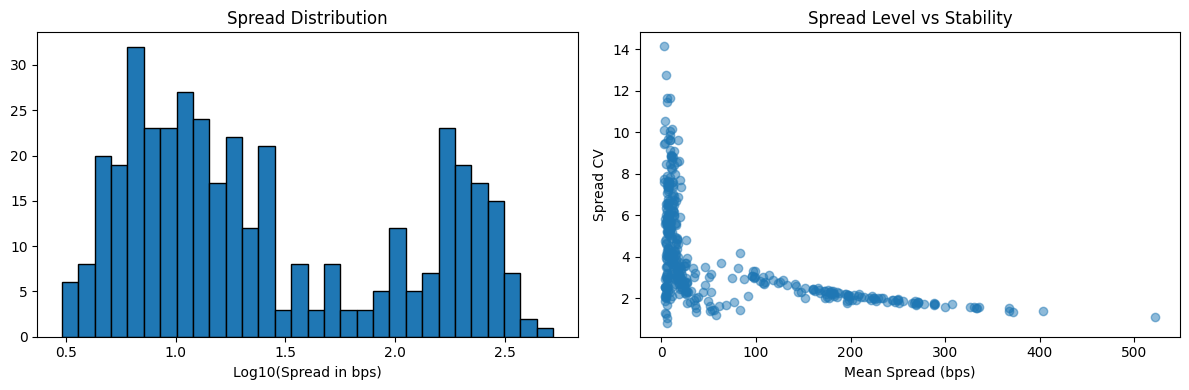

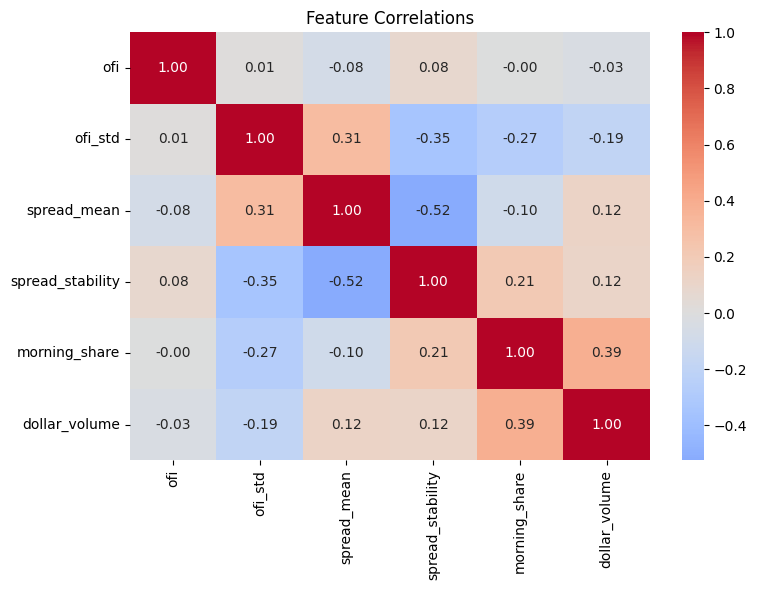


=== Data Quality ===
Missing values:
event_id                   0
permno                     0
date                       0
ofi                        0
ofi_abs                    0
ofi_std                    0
buy_volume                 0
sell_volume                0
volume                     0
num_trades                 0
avg_trade_size             0
classification_method      0
dollar_volume              0
share_volume               0
abnormal_vol_ratio       396
morning_share              0
spread_mean                1
spread_std                 1
spread_stability           1
quoted_spread_mean         1
spread_p95                 1
num_quotes                 0
num_quotes_1s              0
dtype: int64

Classification method:
classification_method
lee_ready    395
tick_test      1
Name: count, dtype: int64

Events: 40
Permnos: 40
Days per event: count    40.000000
mean      9.900000
std       0.632456
min       6.000000
25%      10.000000
50%      10.000000
75%      10.000000
max

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load features
df = pd.read_parquet("../data/processed/daily_features_full.parquet")

# ============================================================
# 1. Basic Stats
# ============================================================
print("=== Feature Summary ===")
print(df.describe())

# ============================================================
# 2. OFI Distribution
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# OFI histogram
axes[0].hist(df['ofi'], bins=30, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_xlabel('OFI')
axes[0].set_title('OFI Distribution (should be centered ~0)')

# OFI by date
df.groupby('date')['ofi'].mean().plot(ax=axes[1])
axes[1].set_ylabel('Mean OFI')
axes[1].set_title('Time Series Stability')

# OFI vs forward returns (placeholder for Phase 2)
axes[2].text(0.5, 0.5, 'Phase 2:\nOFI vs Returns', 
             ha='center', va='center', fontsize=14)
axes[2].set_title('Predictive Power (TODO)')

plt.tight_layout()
plt.show()

# ============================================================
# 3. Spread Analysis
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Spread distribution (log scale)
axes[0].hist(np.log10(df['spread_mean']*10000), bins=30, edgecolor='black')
axes[0].set_xlabel('Log10(Spread in bps)')
axes[0].set_title('Spread Distribution')

# Spread stability
axes[1].scatter(df['spread_mean']*10000, df['spread_stability'], alpha=0.5)
axes[1].set_xlabel('Mean Spread (bps)')
axes[1].set_ylabel('Spread CV')
axes[1].set_title('Spread Level vs Stability')

plt.tight_layout()
plt.show()

# ============================================================
# 4. Cross-Sectional Correlations
# ============================================================
corr_features = ['ofi', 'ofi_std', 'spread_mean', 'spread_stability', 
                 'morning_share', 'dollar_volume']

corr_matrix = df[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

# ============================================================
# 5. Data Quality Checks
# ============================================================
print("\n=== Data Quality ===")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nClassification method:\n{df['classification_method'].value_counts()}")
print(f"\nEvents: {df['event_id'].nunique()}")
print(f"Permnos: {df['permno'].nunique()}")
print(f"Days per event: {df.groupby('event_id').size().describe()}")

# ============================================================
# 6. Sanity Checks
# ============================================================
print("\n=== Sanity Checks ===")

# Buy + Sell should equal Volume
volume_check = np.allclose(
    df['buy_volume'] + df['sell_volume'], 
    df['volume']
)
print(f"Buy + Sell = Volume: {volume_check}")

# OFI should match (buy - sell) / volume
ofi_check = np.allclose(
    (df['buy_volume'] - df['sell_volume']) / df['volume'],
    df['ofi']
)
print(f"OFI formula correct: {ofi_check}")

# Share volume should equal volume
share_volume_check = (df['share_volume'] == df['volume']).all()
print(f"Share volume matches: {share_volume_check}")

print("\n✓ Feature validation complete")